# Working with TIFF (and other) image formats #

TIFF and other image formats are often used to store astronomical images. `aopp_deconv_tool` cannot deconvolve these directly, but routines are available to convert the images into the FITS format and deconvolve the converted image. This example will focus on files in the TIFF format, but converting other formats is done in the same way.

The general strategy is to:

1) Convert the TIFF file to FITS format.
2) Extract the science target and a standard star from the image (this can also be done by supplying two images).
3) Use the standard star to create a model PSF.
4) Deconvolve the science target with the model PSF.


## Finding and converting the TIFF file ##

Initailly we need to find the TIFF file, in this example I will assume example data has been downloaded to a sibling directory "../example_data" relative to the current directory. In the background [pillow](https://pillow.readthedocs.io/en/stable/) is used to read image formats, so a wide range of image formats are supported.



In [1]:

# Import from standard library
from pathlib import Path

# Import from 3rd party
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from astropy.io import fits

# Import from `aopp_deconv_tool` package
import aopp_deconv_tool.to_fits
import aopp_deconv_tool.extract_sources
import aopp_deconv_tool.psf_normalise
import aopp_deconv_tool.fit_psf_model
import aopp_deconv_tool.deconvolve



# NOTE: We assume that the example data has been downloaded 
# and is in the sibling directory "example_data" of the current working directory.
EXAMPLE_DATA_DIR = Path('../example_data')

# Print the directory we are searching as well as the files 
# found within so we know what we are looking at.
print(f'Listing directory {EXAMPLE_DATA_DIR}')
print(f'    TYPE     | PATH')
print(f'    ---------|-----')
for item in EXAMPLE_DATA_DIR.iterdir():
    item_type = 'FILE    ' if item.is_file() else ('FOLDER  ' if item.is_dir() else 'UNKNOWN ')
    print(f'    {item_type} | {item}')

# Example data file we will use for this example
TIFF_FILE = EXAMPLE_DATA_DIR / "2024-01-11-1917_1-Jupiter_750nm.tif"

# Ensure the file exists, otherwise the example will not work
assert TIFF_FILE.is_file(), f"{TIFF_FILE} must be a file"
print(f'{TIFF_FILE} is a file.')

# Create a directory to save outputs from this example
OUTPUT_DIR = Path('./output')
OUTPUT_DIR.mkdir(exist_ok=True)

# Name of the FITS file that we will convert the image to
FITS_FILE = OUTPUT_DIR / "2024-01-11-1917_1-Jupiter_750nm.fits"


# Get the formats `aopp_deconv_tool.to_fits` supports
# these are the same as the [pillow](https://pillow.readthedocs.io/en/stable/) library
# supports on your system
supported_formats = aopp_deconv_tool.to_fits.get_supported_formats()
print('Supported formats: '+ ' '.join(supported_formats))

# Ensure that TIFF files are supported, otherwise the rest of this example will not work
assert any((x in supported_formats for x in ('.tif', '.tiff'))), "TIFF must be a supported format"
print('TIFF is a supported format')

# Peform file conversion
aopp_deconv_tool.to_fits.go(TIFF_FILE, output_path=FITS_FILE)

# Ensure the converted file exists
assert FITS_FILE.is_file(), f"{FITS_FILE} must be a file"
print(f'{FITS_FILE} is a file.')


Aperture(objective aperture,0,Circle(4.0))
[]
Refractor(primary mirror,100,Circle(4.0),focal_length=120)
[0]
0 0 100
Listing directory ../example_data
    TYPE     | PATH
    ---------|-----
    FILE     | ../example_data/single_wavelength_example_std.fits
    FILE     | ../example_data/reduced_data_volume_1_sci.fits
    FILE     | ../example_data/datasets.json
    FILE     | ../example_data/2024-01-11-1951_9-Jupiter_890nm.tif
    FILE     | ../example_data/SMALL_DATACUBE_0001_1_sci.fits
    FILE     | ../example_data/reduced_data_volume_1_std.fits
    FILE     | ../example_data/SMALL_DATACUBE_0001_1_std.fits
    FILE     | ../example_data/single_wavelength_example_sci.fits
    FILE     | ../example_data/2024-01-11-1932_7-Jupiter_890nm.tif
    FILE     | ../example_data/2024-01-11-1957_2-Jupiter_750nm.tif
    FILE     | ../example_data/2024-01-11-1917_1-Jupiter_750nm.tif
    FILE     | ../example_data/2024-01-11-1925_9-Jupiter_727nm.tif
../example_data/2024-01-11-1917_1-Jupiter_750nm.t

The example file has been converted, to be sure of success we will display both versions side-by-side to make sure they are identical.

## Comparing TIFF and FITS versions ##

A plotting function is provided for convenience.


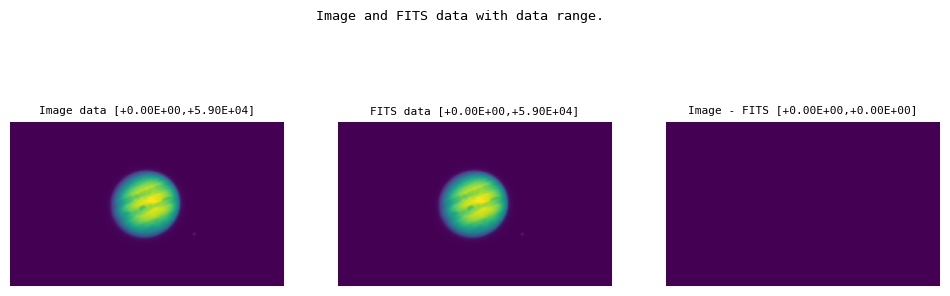

In [2]:
fig, ax = aopp_deconv_tool.to_fits.plot_image_and_fits(TIFF_FILE, FITS_FILE, slices=(0,slice(None),slice(None)))
plt.show() # Show the plot once it has been created

The title of each frame contains the name of the frame, and the smallest and largest values in the image inside square brackets. Therefore, from the above plot, it is easy to see the image and FITS versions of the same data are identical. The right-hand plot "Image - FITS" shows the difference between the two images. The smallest and largest pixel values are zero, so the images contain identical data.

For a TIFF file, metadata is transferred to the FITS file as much as is possible, the TIFF metadata keys and values are stored in the FITS file's "PKEYn" and "PVALn" header entries respectively. The following code snippet prints the metadata for both versions of the file.

In [3]:
image_bundle = aopp_deconv_tool.to_fits.read_image_into_data_bundle(TIFF_FILE)
fits_header = fits.getheader(FITS_FILE)

print('Image Metadata ---------------------------------------------------------')
for k,v in image_bundle.header.items():
    print(f'|   {k} : {v}')
    
print('\n')
print('FITS Metadata ----------------------------------------------------------')
for k,v in fits_header.items():
    if k.startswith('PKEY'):
        print(f'|   {v} : ', end='')
    elif k.startswith('PVAL'):
        print(f'{v}')

Image Metadata ---------------------------------------------------------
|   ImageWidth : 1000
|   ImageLength : 600
|   BitsPerSample : 16
|   Compression : 1
|   PhotometricInterpretation : 1
|   ResolutionUnit : 2
|   FillOrder : 1
|   StripOffsets : (8, 8008, 16008, 24008, 32008, 40008, 48008, 56008, 64008, 72008, 80008, 88008, 96008, 104008, 112008, 120008, 128008, 136008, 144008, 152008, 160008, 168008, 176008, 184008, 192008, 200008, 208008, 216008, 224008, 232008, 240008, 248008, 256008, 264008, 272008, 280008, 288008, 296008, 304008, 312008, 320008, 328008, 336008, 344008, 352008, 360008, 368008, 376008, 384008, 392008, 400008, 408008, 416008, 424008, 432008, 440008, 448008, 456008, 464008, 472008, 480008, 488008, 496008, 504008, 512008, 520008, 528008, 536008, 544008, 552008, 560008, 568008, 576008, 584008, 592008, 600008, 608008, 616008, 624008, 632008, 640008, 648008, 656008, 664008, 672008, 680008, 688008, 696008, 704008, 712008, 720008, 728008, 736008, 744008, 752008, 760

The metadata is identical, but accessing it in the FITS file is a bit different than in a TIFF file.

From now on we will operate on the FITS file instead of the TIFF file as the routines in `aopp_deconv_tool` assume a FITS file as input.

## Getting a PSF ##

The image we have at the moment is an observation of Jupiter, we do not have a corresponding standard star observation taken at the same sky and telescope conditions we can use as a PSF. However, there are objects in the field that we can use we just have to extract one of them. Complicating things is that Jupiter has many moons, one of which is actually resolved to the bottom right of Jupiter (if you look carefully). For the purposes of a PSF we do not care about the brightness of a source, only that it is unresolved and can be assumed to be a point source. Therefore a star in the field, or an unresolved moon is good enough for our purposes.





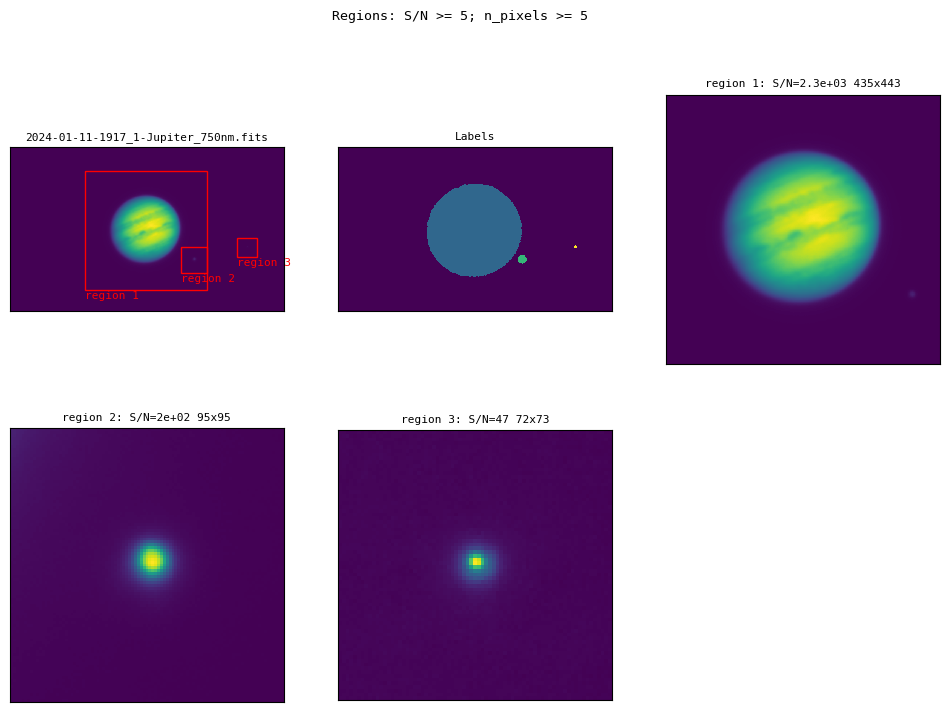

2024-09-05T18:05:21 +0100 extract_sources.py:275 "run" INFO: Written source 1 to output/2024-01-11-1917_1-Jupiter_750nm_source_1.fits
2024-09-05T18:05:21 +0100 extract_sources.py:275 "run" INFO: Written source 2 to output/2024-01-11-1917_1-Jupiter_750nm_source_2.fits
2024-09-05T18:05:21 +0100 extract_sources.py:275 "run" INFO: Written source 3 to output/2024-01-11-1917_1-Jupiter_750nm_source_3.fits


In [4]:
aopp_deconv_tool.extract_sources._lgr.setLevel('INFO') # set this so we can see the output file names
aopp_deconv_tool.extract_sources.go(FITS_FILE, plot_FLAG=True)

From the above plots, we can see that "region 3" (corresponding to source 3) is small and possibly can be used as a point source. Therefore, we can use the "output/2024-01-11-1917_1-Jupiter_750nm_source_3.fits" FITS file as a PSF for deconvolving the Juipter observation.

## Creating a model PSF ##

Instead of using "output/2024-01-11-1917_1-Jupiter_750nm_source_3.fits" directly as a PSF, we will instead fit a model to it and use the resulting model. In this case, it isn't too bad to use the FITS file directly but in some cases it can be useful to reduce the amount of noise present in the system.

We still have to normalise the PSF before we model it as the model assumes a normalised object. One slight problem is that as we made the PSF file from a TIFF image, the FITS file does not have any information about which axes correspond to which physical quantities. We can either edit the FITS file (e.g. using QFitsView) and add this information, or send the information with the filename. To do the latter, we just have to append the axes that correspond to the sky parameters to the filename.

### Normalise the PSF first ###

2024-09-05T18:05:21 +0100 psf_normalise.py:58 "run" INFO: Remove NANs and INFs
2024-09-05T18:05:21 +0100 psf_normalise.py:61 "run" INFO: Ensure data is of odd shape
2024-09-05T18:05:21 +0100 psf_normalise.py:66 "run" INFO: Remove any outliers
2024-09-05T18:05:21 +0100 psf_normalise.py:72 "run" INFO: Remove background offset
2024-09-05T18:05:21 +0100 psf_normalise.py:80 "run" INFO: Get offsets to centre around centre of mass
2024-09-05T18:05:21 +0100 psf_normalise.py:85 "run" INFO: Recentre everything for easy comparison
2024-09-05T18:05:21 +0100 psf_normalise.py:110 "run" INFO: Normalise to unit sum
2024-09-05T18:05:21 +0100 psf_normalise.py:136 "run" INFO: save the products to a FITS file
2024-09-05T18:05:21 +0100 psf_normalise.py:199 "run" INFO: Written normalised psf to output/2024-01-11-1917_1-Jupiter_750nm_source_3_normalised.fits


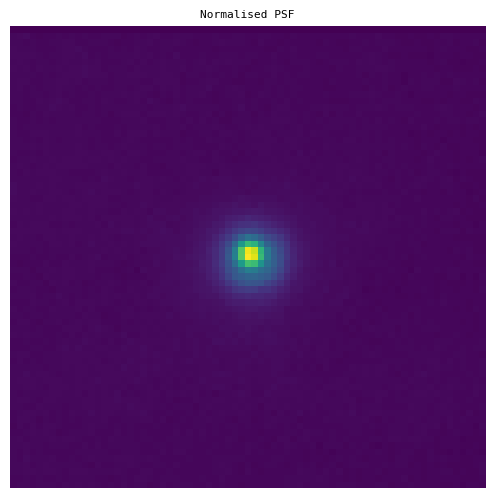

In [5]:
PSF_FILE = "output/2024-01-11-1917_1-Jupiter_750nm_source_3.fits"
CELESTIAL_AXES="(1,2)" # Note: this a 0-based index, not a 1-based index.
PSF_FILE_NORM = "output/2024-01-11-1917_1-Jupiter_750nm_source_3_normalised.fits"

aopp_deconv_tool.psf_normalise._lgr.setLevel('INFO')
aopp_deconv_tool.psf_normalise.go(PSF_FILE+CELESTIAL_AXES, output_path=PSF_FILE_NORM)

plt.title('Normalised PSF')
plt.imshow(fits.getdata(PSF_FILE_NORM)[0])
plt.gca().set_axis_off()
plt.show()

After the PSF is normalised, we can model it.

### Fit a model to the normalised psf ###

`aopp_deconv_tool` provides a few different PSF models, the one applicable to the most situation is the "radial" model. This model just fits a radial histogram to the input image.


  'PIXEL' -> 'pixel'. [astropy.wcs.wcs]
2024-09-05T18:05:21 +0100 logger.py:235 "_showwarning" WARNING: FITSFixedWarning: 'unitfix' made the change 'Changed units:
  'PIXEL' -> 'pixel'.
/home/dobinsonl/Documents/repos/aopp_obs_toolchain/src/aopp_deconv_tool/psf_model/radial_psf_model.py:29: RuntimeWarning: Mean of empty slice
  self.r_values[i] = np.nanmean(self.data[r_mask])
/home/dobinsonl/Documents/repos/aopp_obs_toolchain/src/aopp_deconv_tool/psf_data_ops.py:471: RuntimeWarning: divide by zero encountered in divide
  result = np.nansum((residual/err)**2)
/home/dobinsonl/Documents/repos/aopp_obs_toolchain/.venv_3.12.2/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/dobinsonl/Documents/repos/aopp_obs_toolchain/src/aopp_deconv_tool/psf_data_ops.py:471: RuntimeWarning: invalid value encountered in divide
  result = np.nansum((residual/err)**2)
2024-09-05T18:05:21 +0100 fit_psf_model.py:293 "run"

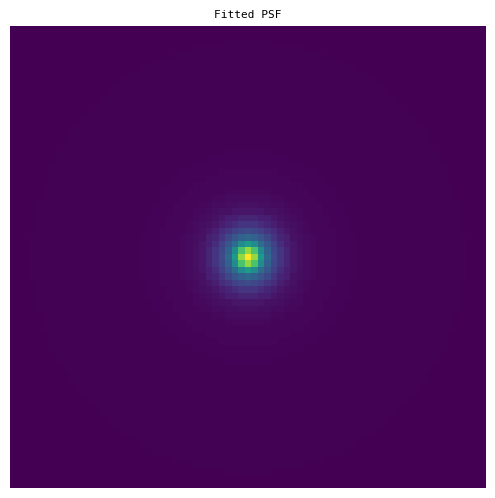

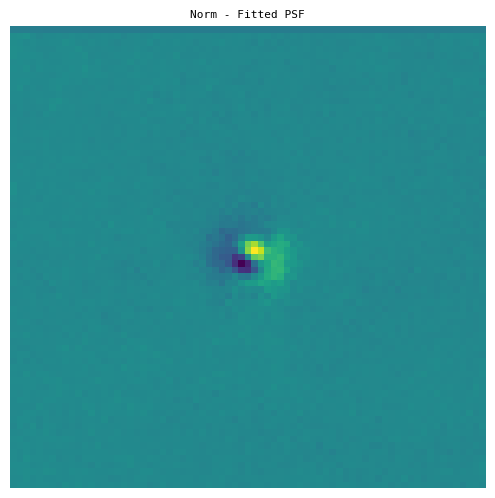

In [6]:
PSF_FILE_FITTED = "output/2024-01-11-1917_1-Jupiter_750nm_source_3_normalised_radial_fit.fits"

aopp_deconv_tool.fit_psf_model._lgr.setLevel('INFO')
aopp_deconv_tool.fit_psf_model.go(PSF_FILE_NORM+CELESTIAL_AXES, output_path=PSF_FILE_FITTED, model='radial', nbins=50, error_factor=1E-3)

fitted_psf_data = fits.getdata(PSF_FILE_FITTED)[0]
norm_psf_data = fits.getdata(PSF_FILE_NORM)[0]

plt.title('Fitted PSF')
plt.imshow(fitted_psf_data)
plt.gca().set_axis_off()
plt.show()

plt.title('Norm - Fitted PSF')
plt.imshow(norm_psf_data - fitted_psf_data)
plt.gca().set_axis_off()
plt.show()

From the above plots it is obvious that the normalised PSF is assymetric, and the fitted PSF actually looks quite different. We could use a different PSF model, but this works well enough for our purposes.

## Deconvolution ##

The deconvolution is performed the same way as in any other case, as we have a science observation and a PSF to go with it.

In [7]:
SCI_FILE_DECONV = "./output/2024-01-11-1917_1-Jupiter_750nm_deconv.fits"

#import aopp_deconv_tool.algorithm.deconv.clean_modified
#aopp_deconv_tool.algorithm.deconv.clean_modified._lgr.setLevel('DEBUG')

aopp_deconv_tool.deconvolve._lgr.setLevel('INFO')
aopp_deconv_tool.deconvolve.go(
    FITS_FILE, 
    PSF_FILE_FITTED, 
    output_path=SCI_FILE_DECONV, 
    deconv_method='clean_modified', 
    threshold=-1, 
    fabs_frac_threshold=1E-3, 
    rms_frac_threshold=1E-3,
    progress=1,
)



2024-09-05T18:10:59 +0100 deconvolve.py:332 "run" INFO: Deconvolution completed, output written to "output/2024-01-11-1917_1-Jupiter_750nm_deconv.fits"


Iteration 998/1000 [99.8%]


To get a sense of how the deconvolution went, look at the deconvolution key-value pairs in the header of the FITS file.

In [8]:
deconv_sci_header = fits.getheader(SCI_FILE_DECONV)

print_kv_flag = False
for k,v in deconv_sci_header.items():
    if print_kv_flag:
        print(f' : {v}')
        print_kv_flag = False
    if type(v) is str and v.startswith('deconv.'):
        print_kv_flag = True
        print(v, end='')
    

deconv.obs_file : output/2024-01-11-1917_1-Jupiter_750nm.fits
deconv.psf_file : output/2024-01-11-1917_1-Jupiter_750nm_source_3_normalised_radial_fit.fits
deconv.parameters_recorded_at_timestamp : 2024-09-05T17:10:59.828586+0000
deconv.n_iter : 1000
deconv.progress_string : Ended at 998 iterations: Standard deviation of statistics in last 10 steps are all below minimum fraction as defined in `min_frac_stat_delta` parameter.
deconv.loop_gain : 0.02
deconv.threshold : -1.0
deconv.n_positive_iter : 0
deconv.noise_std : 0.1
deconv.rms_frac_threshold : 0.001
deconv.fabs_frac_threshold : 0.001
deconv.max_stat_increase : inf
deconv.min_frac_stat_delta : 0.001
deconv.give_best_result : False
deconv.clean_beam_sigma : 0


Finally we want to compare the original image and deconvolved image.

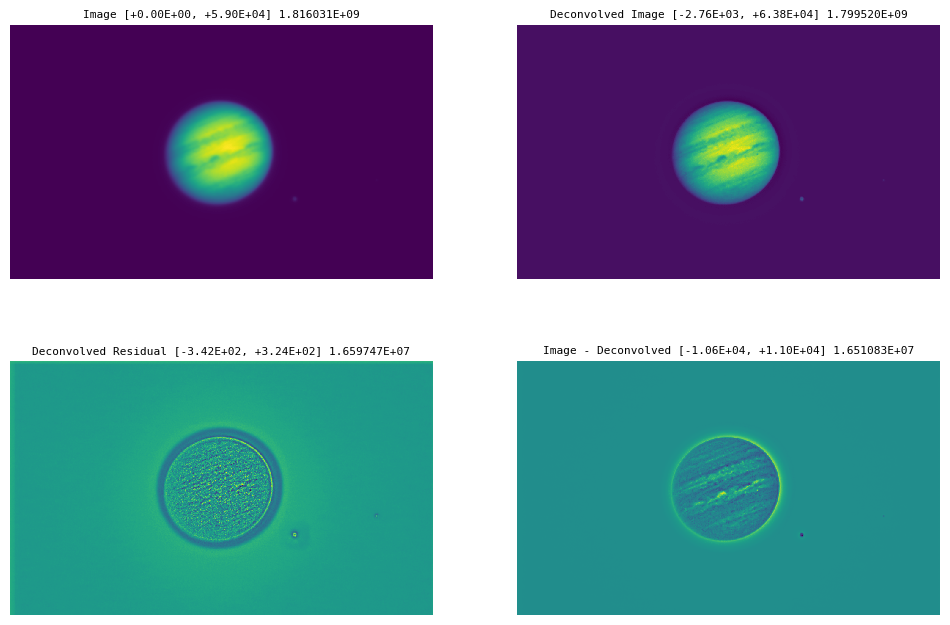

In [11]:
deconv_sci_data = fits.getdata(SCI_FILE_DECONV)[0]
deconv_sci_residual = fits.getdata(SCI_FILE_DECONV, ext=1)[0]
sci_data = fits.getdata(FITS_FILE)[0]
sci_deconv_diff = sci_data - deconv_sci_data


fig, ax = plt.subplots(2,2, figsize=(12,8))
ax = ax.flatten()

ax[0].set_title(f'Image [{np.nanmin(sci_data):+9.2E}, {np.nanmax(sci_data):+9.2E}] {np.nansum(sci_data):E}')
ax[0].imshow(sci_data)
ax[0].set_axis_off()

ax[1].set_title(f'Deconvolved Image [{np.nanmin(deconv_sci_data):+9.2E}, {np.nanmax(deconv_sci_data):+9.2E}] {np.nansum(deconv_sci_data):E}')
ax[1].imshow(deconv_sci_data)
ax[1].set_axis_off()

ax[2].set_title(f'Deconvolved Residual [{np.nanmin(deconv_sci_residual):+9.2E}, {np.nanmax(deconv_sci_residual):+9.2E}] {np.nansum(deconv_sci_residual):E}')
ax[2].imshow(deconv_sci_residual)
ax[2].set_axis_off()

ax[3].set_title(f'Image - Deconvolved [{np.nanmin(sci_deconv_diff):+9.2E}, {np.nanmax(sci_deconv_diff):+9.2E}] {np.nansum(sci_deconv_diff):E}')
ax[3].imshow(sci_deconv_diff)
ax[3].set_axis_off()

plt.show()

Comparing the image and the deconvolved image shows that the deconvolution process enhances the spatial resolution, and keeps the total flux in the image constant to about the 1% level (as seen in the image sum, the number not in square brackets). 

The reason for the difference between the residual (bottom left frame) and the bottom right frame is that the residual is calculated by first re-convolving the deconvolved image with the PSF, then subtracting it from the image. Note the scales in square brackets when comparing the bottom frames to the top frames.